In [2]:
import numpy as np 
import pandas as pd 


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
df = pd.read_csv(r'C:\Users\thaku\Downloads\archive\covtype.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

Checking the range for the features to see if they have to scaled or not for logistic regression

In [5]:
# transpose (.T) - to make it easier to read as a list
stats = df.describe().T[['min', 'max']]
print(stats)

                                       min     max
Elevation                           1859.0  3858.0
Aspect                                 0.0   360.0
Slope                                  0.0    66.0
Horizontal_Distance_To_Hydrology       0.0  1397.0
Vertical_Distance_To_Hydrology      -173.0   601.0
Horizontal_Distance_To_Roadways        0.0  7117.0
Hillshade_9am                          0.0   254.0
Hillshade_Noon                         0.0   254.0
Hillshade_3pm                          0.0   254.0
Horizontal_Distance_To_Fire_Points     0.0  7173.0
Wilderness_Area1                       0.0     1.0
Wilderness_Area2                       0.0     1.0
Wilderness_Area3                       0.0     1.0
Wilderness_Area4                       0.0     1.0
Soil_Type1                             0.0     1.0
Soil_Type2                             0.0     1.0
Soil_Type3                             0.0     1.0
Soil_Type4                             0.0     1.0
Soil_Type5                     

**The range of Elevation (2000) is almost 30 times larger than Slope & 2000 times larger than Soil_Type which is a binary column. It proves that the scales are incompatible and normalization is required for SVM and neural networks models.**

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

Checking how the target variable is distributed 

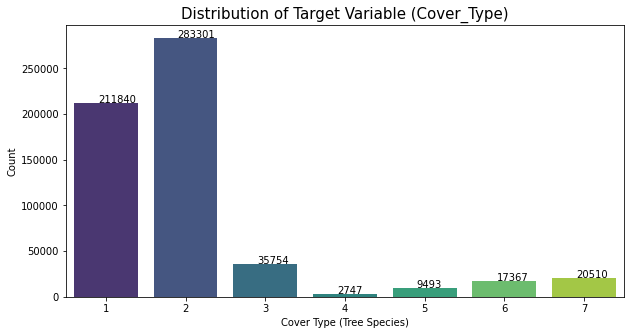

In [7]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='Cover_Type', data=df, palette='viridis')
plt.title('Distribution of Target Variable (Cover_Type)', fontsize=15)
plt.xlabel('Cover Type (Tree Species)')
plt.ylabel('Count')


for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + 0.3, p.get_height() + 50))
plt.show()

We can see from the above plot that the distribution is not balannced. Because Classes 1 and 2 are so dominant, a lazy model could guess Class 2 for every single row and still achieve a very high accuracy (likely over 50%), despite failing completely to identify any of the other tree types.

Plotting boxplot to check if a specific feature (like Elevation or Slope) can effectively separate the different tree species.

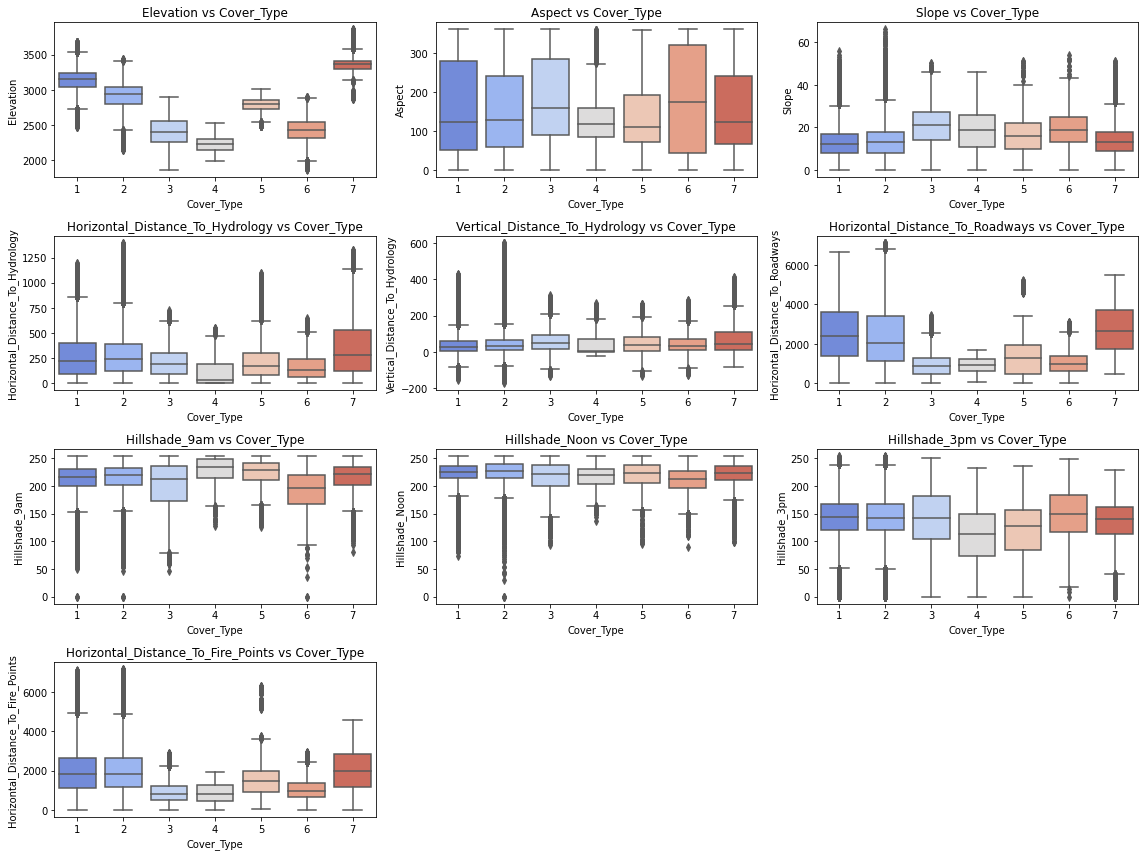

In [8]:
# Selected only continuous columns
column_nonbin = df.columns[:10]

plt.figure(figsize=(16, 12))
for i, col in enumerate(column_nonbin):
    plt.subplot(4, 3, i+1)
    sns.boxplot(x='Cover_Type', y=col, data=df, palette='coolwarm')
    plt.title(f'{col} vs Cover_Type')
plt.tight_layout()
plt.show()

Elevation is the Strongest Predictor- The boxplots reveal distinct elevation bands for different tree species; for example, Type 7 thrives exclusively at the highest altitudes (>3000m), while Type 4 is confined to lower elevations (~2200m).

Specific Habitat Preferences- The boxplots for Horizontal_Distance_To_Roadways show that Cottonwood/Willow trees are found near roads, likely indicating their presence in accessible valley floors.

Plotting the Correlation Matrix for continuous data to reduce multicollinearity.

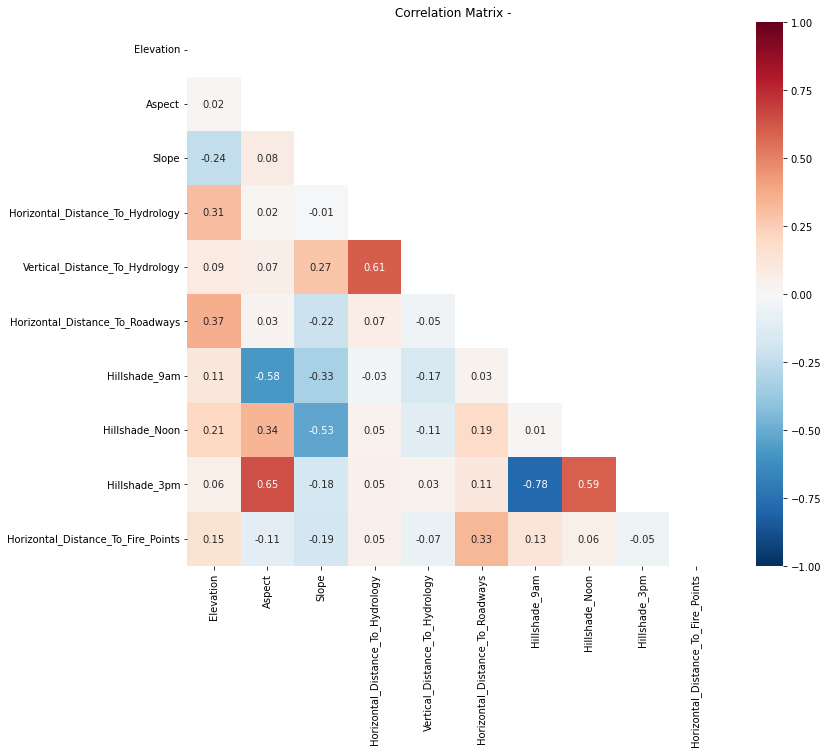

In [9]:
plt.figure(figsize=(12, 10))
# Calculating correlation on non-binary columns
corr = df[column_nonbin].corr()
mask = np.triu(np.ones_like(corr, dtype=bool)) 
sns.heatmap(corr,mask = mask, annot=True, fmt=".2f", cmap='RdBu_r', vmin=-1, vmax=1)
plt.title('Correlation Matrix - ')
plt.show()

The correlation heatmap shows a strong negative correlation (-0.78) between Hillshade_9am and Hillshade_3pm, which tells that these features carry conflicting information (morning vs. afternoon sun). So we remove one feature to prevent multicollinearity in linear models.

Reverse Encoding Wilderness Areas (columns 10-13) and Encode Soil Types columns(14 - 54)

In [10]:
# idxmax returns the column name with the highest value (the '1')
df['Wilderness_Area_Label'] = df.iloc[:, 10:14].idxmax(axis=1)
df['Soil_Type_Label'] = df.iloc[:, 14:54].idxmax(axis=1)

# Changing the names to numbers for easier readability(e.g., 'Soil_Type1' -> 1)
df['Soil_Type_Label'] = df['Soil_Type_Label'].apply(lambda x: int(x.replace('Soil_Type', '')))


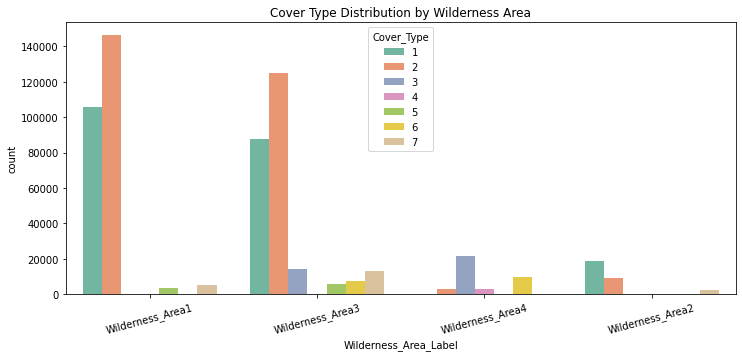

In [11]:
# plotting for Wilderness Area Distribution
plt.figure(figsize=(12, 5))
sns.countplot(x='Wilderness_Area_Label', hue='Cover_Type', data=df, palette='Set2')
plt.title('Cover Type Distribution by Wilderness Area')
plt.xticks(rotation=15)
plt.show()

The wilderness area chart highlights that certain zones, such as Wilderness Area 4, contain tree populations (Types 3 and 6) that are almost absent in other areas, making location a critical discriminator.

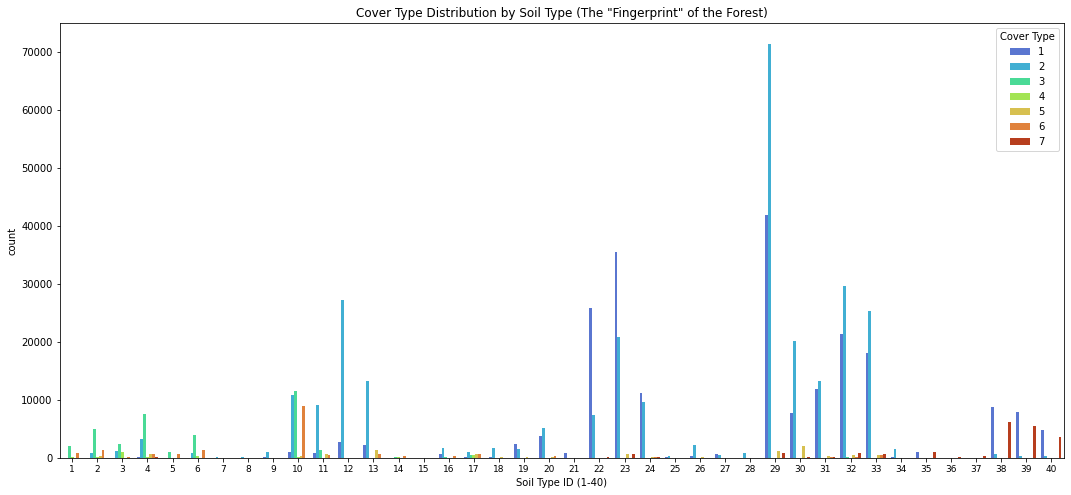

In [12]:
# plotting for Soil Type Distribution
plt.figure(figsize=(18, 8))
sns.countplot(x='Soil_Type_Label', hue='Cover_Type', data=df, palette='turbo')
plt.title('Cover Type Distribution by Soil Type (The "Fingerprint" of the Forest)')
plt.xlabel('Soil Type ID (1-40)')
plt.legend(loc='upper right', title='Cover Type')
plt.xticks(fontsize=9)
plt.show()

The soil type distribution chart displays sharp spikes where specific soil IDs (like Soil Type 10) correlate almost 100% with a single tree species (Type 6), providing highly specific rules for classification.

In [13]:
# importing the required modules
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix


In [14]:
# 10% Stratified Sample - subsampling so that training can be done faster
# To speed up the training data
print(f"Original Size: {len(df)}")
df, _ = train_test_split(df, train_size=0.1, stratify=df['Cover_Type'], random_state=42)
print(f"Sampled Size:  {len(df)} (Using this for speed)")

Original Size: 581012
Sampled Size:  58101 (Using this for speed)


In [15]:
# Feature Engineering
# Creating "Distance to Hydrology" - hypotenuse (combining two weak features to make  a stronger feature)
df['Dist_To_Hydrology'] = np.sqrt(df['Horizontal_Distance_To_Hydrology']**2 + 
                                  df['Vertical_Distance_To_Hydrology']**2)

Preparing the Input and Target Features for the diff models-
For logistic regression reducing collinearity

In [17]:
y = df['Cover_Type'].values

# For SVM & NN
X_all_df = df.drop(['Cover_Type', 'Wilderness_Area_Label', 'Soil_Type_Label'], axis=1, errors='ignore')
X_all = X_all_df.values

# For LogReg (Removed 'Hillshade_9am' to reduce multicollinearity)
X_log_df = X_all_df.drop('Hillshade_9am', axis=1)
X_log = X_log_df.values

# Identifying Continuous Columns for Scaling (Normalisation)
# Indices of first 10 cols + the new distance col at the end
cont_cols_all = list(range(0, 10)) + [X_all.shape[1] - 1] 
cont_cols_log = list(range(0, 9)) + [X_log.shape[1] - 1]

Why using stratified data - Standard random splitting might accidentally put all the "Cottonwood" trees in the test set and none in the training set. Stratified splitting guarantees that if 5% of trees are Cottonwood, exactly 5% are in the training set and 5% are in the test set.

metrics - We need a place to store the test scores. This dictionary creates empty lists for every metric (Accuracy, F1, etc.) for every model so we can save the results of each "Fold" later.

In [18]:
# Setup K-Fold
models = ['Logistic Regression', 'SVM (SGD)', 'Neural Network']
metrics = {m: {'acc': [], 'f1': [], 'prec': [], 'rec': [], 'cm': 0} for m in models}

k = 3
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)



In [ ]:
Using k-fold Cross-Validation instead of train test split to ensure reliability.
Training the Models and getting the results for comparative analysis.


Starting 3-Fold Cross-Validation...
Processing Fold 1/3...


c:\Users\thaku\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\thaku\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Processing Fold 2/3...


c:\Users\thaku\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\thaku\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Processing Fold 3/3...


c:\Users\thaku\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\thaku\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(



Model                | Accuracy   | F1 Score   | Precision  | Recall    
--------------------------------------------------------------------
Logistic Regression  | 0.7237     | 0.7132     | 0.7130    | 0.7237
SVM (SGD)            | 0.6857     | 0.6531     | 0.6377    | 0.6857
Neural Network       | 0.8087     | 0.8056     | 0.8076    | 0.8087


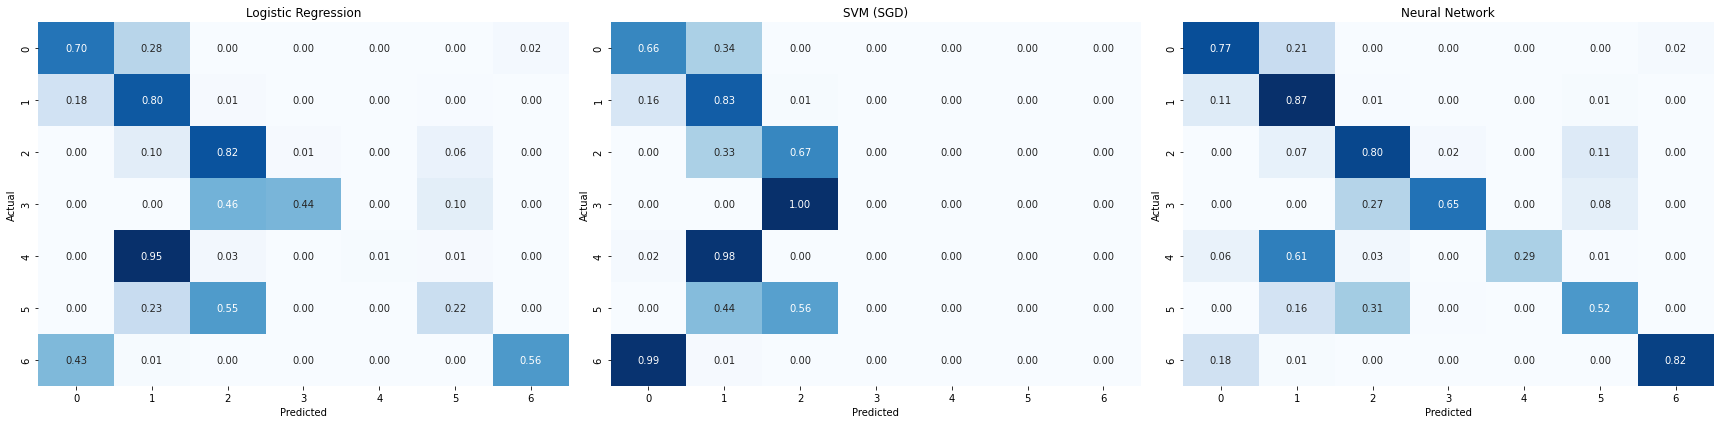

In [19]:
print(f"\nStarting {k}-Fold Cross-Validation...")
# --- 4. Main Loop ---
for fold, (train_idx, val_idx) in enumerate(skf.split(X_all, y)):
    print(f"Processing Fold {fold+1}/{k}...")
    y_train, y_val = y[train_idx], y[val_idx]


    #  MODEL 1: Logistic Regression 
    X_train_log, X_val_log = X_log[train_idx], X_log[val_idx]
    
    # Scaling the data using StandardScalar

    scaler = StandardScaler()
    X_train_log[:, cont_cols_log] = scaler.fit_transform(X_train_log[:, cont_cols_log])
    X_val_log[:, cont_cols_log] = scaler.transform(X_val_log[:, cont_cols_log])
    
    # Training the model (Added tol=1e-3 for faster convergence)
    lr = LogisticRegression(solver='saga', max_iter=100, tol=1e-3, n_jobs=-1, multi_class='multinomial')
    lr.fit(X_train_log, y_train)
    preds_lr = lr.predict(X_val_log)
    
    # Storing the results in the metrics list
    metrics['Logistic Regression']['acc'].append(accuracy_score(y_val, preds_lr))
    metrics['Logistic Regression']['f1'].append(f1_score(y_val, preds_lr, average='weighted', zero_division=0))
    metrics['Logistic Regression']['prec'].append(precision_score(y_val, preds_lr, average='weighted', zero_division=0))
    metrics['Logistic Regression']['rec'].append(recall_score(y_val, preds_lr, average='weighted', zero_division=0))
    metrics['Logistic Regression']['cm'] += confusion_matrix(y_val, preds_lr)


    # SETUP FOR SVM & NN 
    X_train_all, X_val_all = X_all[train_idx], X_all[val_idx]
    
    scaler_all = StandardScaler()
    X_train_all[:, cont_cols_all] = scaler_all.fit_transform(X_train_all[:, cont_cols_all])
    X_val_all[:, cont_cols_all] = scaler_all.transform(X_val_all[:, cont_cols_all])

    # MODEL 2: SVM (SGD) 
    svm = SGDClassifier(loss='hinge', penalty='l2', alpha=0.01, max_iter=100, n_jobs=-1, random_state=42)
    svm.fit(X_train_all, y_train)
    preds_svm = svm.predict(X_val_all)
    
    metrics['SVM (SGD)']['acc'].append(accuracy_score(y_val, preds_svm))
    metrics['SVM (SGD)']['f1'].append(f1_score(y_val, preds_svm, average='weighted', zero_division=0))
    metrics['SVM (SGD)']['prec'].append(precision_score(y_val, preds_svm, average='weighted', zero_division=0))
    metrics['SVM (SGD)']['rec'].append(recall_score(y_val, preds_svm, average='weighted', zero_division=0))
    metrics['SVM (SGD)']['cm'] += confusion_matrix(y_val, preds_svm)

    # MODEL 3: Neural Network

    # batch_size=256 for faster epoch completion
    mlp = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', 
                        batch_size=256, max_iter=50, early_stopping=True, random_state=42)
    mlp.fit(X_train_all, y_train)
    preds_mlp = mlp.predict(X_val_all)
    
    metrics['Neural Network']['acc'].append(accuracy_score(y_val, preds_mlp))
    metrics['Neural Network']['f1'].append(f1_score(y_val, preds_mlp, average='weighted', zero_division=0))
    metrics['Neural Network']['prec'].append(precision_score(y_val, preds_mlp, average='weighted', zero_division=0))
    metrics['Neural Network']['rec'].append(recall_score(y_val, preds_mlp, average='weighted', zero_division=0))
    metrics['Neural Network']['cm'] += confusion_matrix(y_val, preds_mlp)

# Printing the Final Output

print("\n" + "="*60)
print(f"{'Model':<20} | {'Accuracy':<10} | {'F1 Score':<10} | {'Precision':<10} | {'Recall':<10}")
print("-" * 68)

for name, res in metrics.items():
    print(f"{name:<20} | {np.mean(res['acc']):.4f}     | {np.mean(res['f1']):.4f}     | {np.mean(res['prec']):.4f}    | {np.mean(res['rec']):.4f}")

print("="*60)


# Plot Normalized Confusion Matrices

fig, axes = plt.subplots(1, 3, figsize=(24, 6))
for i, (name, res) in enumerate(metrics.items()):
    cm = res['cm']
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # Normalize rows
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', ax=axes[i], cbar=False)
    axes[i].set_title(f'{name}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

Our experiments showed that the Neural Network was definitely the best model, hitting an accuracy of 80.87% and beating both Logistic Regression (72.37%) and the Linear SVM (68.57%). The main reason the simpler models failed was that they couldn't tell the difference between Spruce/Fir (Type 1) and Lodgepole Pine (Type 2), which the confusion matrices showed were getting mixed up constantly. The Neural Network handled this much better, likely because it could actually learn the specific "rules" about which soil types belong to which tree. We also confirmed that removing the Hillshade_9am variable was the right call, since the heatmap showed it was basically a duplicate of the afternoon shade data. Overall, this proves that while basic features like elevation are important, we need a complex model like a Neural Networks to understand the complicated patterns in this dataset.

Using PCA to compress the features-

Instead of using all original columns, calculating a smaller set of new features that retain 95% of the original information (variance).
Fitting this compression logic on the training data and applying on the validation data.

Training a Neural Network (MLPClassifier) using only these compressed PCA features and then calculating the accuracy on the validation set to see if the compression helped or hurt performance.

In [20]:
from sklearn.decomposition import PCA


k = 3
print(f"Starting {k}-Fold Cross-Validation with PCA...")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_all, y)):
    print(f"Processing Fold {fold+1}/{k}...")
    
    # 1. Splitting the data

    X_train, X_val = X_all[train_idx], X_all[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    # 2. Scaling the data

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # 3. Applying PCA
    # n_components=0.95 
    pca = PCA(n_components=0.95, random_state=42)
    
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_val_pca = pca.transform(X_val_scaled)
    
    print(f"  > PCA reduced features from {X_train.shape[1]} to {X_train_pca.shape[1]}")

    # Setting the hyperparameters for the NN model-

    mlp = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', 
                        batch_size=256, max_iter=100, early_stopping=True, random_state=42)
    
    mlp.fit(X_train_pca, y_train) # Training on PCA data
    preds_mlp = mlp.predict(X_val_pca) # Predicting on PCA data
    
    acc = accuracy_score(y_val, preds_mlp)
    print(f"  > NN Accuracy with PCA: {acc:.4f}")

Starting 3-Fold Cross-Validation with PCA...
Processing Fold 1/3...
  > PCA reduced features from 55 to 43


c:\Users\thaku\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


  > NN Accuracy with PCA: 0.7971
Processing Fold 2/3...
  > PCA reduced features from 55 to 43
  > NN Accuracy with PCA: 0.7785
Processing Fold 3/3...
  > PCA reduced features from 55 to 43
  > NN Accuracy with PCA: 0.7872


From comparing both the results, we can see that the accuracy has reduced from 80.0% to 78.7 when applied PCA as it is generally bad for tabular data with categorical variables (like Soil Types).

Hyperparameters for Optimized NN Model -

Activation function-
Using activation='relu' for the hidden layers. This function outputs 0 if the input is negative, and the raw input if it is positive (f(x) = max(0, x)).

1.ReLU does not squash positive numbers. The gradient is always 1 for active neurons. This allows the signal to travel through deep layers without vanishing, allowing our network to learn the complex, deep patterns in the forest data.

2.ReLU outputs true zeros. This means that for any given input, some neurons are completely "turned off." This creates a "sparse" network, which is often better at handling messy, high-dimensional data like 40 binary soil types.


Finding the minimum error - 

We used solver='adam' instead of the standard Stochastic Gradient Descent (sgd).

1.Adam has an "Adaptive Learning Rate." It doesn't use the same speed for every feature. It automatically speeds up learning for rare features (like rare soil types) and slows it down for frequent features (like Elevation). This is critical for catching those rare "Soil Type" signals.

2.Adam auto-tunes its learning rate during training, making it much more robust and easier to use

In [ ]:
mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128),  # Wide first layer to catch Soil/Wilderness interactions
    activation='relu',
    solver='adam',
    alpha=0.0001,                   # Low regularization
    learning_rate_init=0.001,       # Standard Adam rate
    batch_size=1024,                # Larger batch size stabilizes gradients
    max_iter=300,                   # Needs time to converge
    early_stopping=True,
    random_state=42
)
mlp.fit(X_train_all, y_train) # Training on PCA data
preds_mlp = mlp.predict(X_val_all) # Predicting on PCA data
    
acc = accuracy_score(y_val, preds_mlp)
print(f"  > NN Accuracy after running optuna: {acc:.4f}")

  > NN Accuracy after running optuna: 0.8528


Optimised Neural networks model out of all three because it had the highest accuracy and eval metrics using Optuna. After n trials we came with this set of hyperparameters which produced the highest accuracy on this dataset.